<a href="https://colab.research.google.com/github/CMedrado/Topicosemcomputa-o/blob/main/Eclipse_Model_Severity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Texto no contexto da Predição de Severidade de Bug Reports

Exemplo de classificação de texto com pipeline de NLP e classificador no final

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [3]:
# Tokenização
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    
    # Stemização
    stems  = []
    for item in tokens:
        stems.append(SnowballStemmer("english").stem(item))
    return stems

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Carregando os dados
df = pd.read_csv('/content/drive/My Drive/TP/PF/Dataset (1)/Eclipse_total.csv') # Salvamos com esse nome antes

# Dataset
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,221036,Community,unabl enter request parti code cq,report enter request parti librari submit java...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver bjorn.freeman-benson karl.matthias,FIXED
1,221203,Community,submit request cq cq submit,submit request cq cq submit creat screen retur...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver d_a_carver bjorn.freeman-benson kar...,FIXED
2,243952,Community,ca submit cq rd parti contribut develop apach,valid apach url enter url project page apach p...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,ekuleshov ekuleshov bjorn.freeman-benson ekule...,FIXED
3,230229,Community,tool link fail ie,webmast email tool link respond js error error...,Project Management & Portal,blocker,P1,gabe.obrien,webmaster webmaster bjorn.freeman-benson karl....,FIXED
4,229095,Community,cron total broken,portal cron job broken friday gabe debug fix c...,Project Management & Portal,blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias karl...,FIXED
5,109230,Community,gener roadmap project inform file,xslt css gener roadmap eclipse project info xm...,Process,critical,P1,eromero,bjorn.freeman-benson techtonik bjorn.freeman-b...,FIXED
6,275926,Community,cq for record blow address charact,appear addslash stripslash appli properli case...,Project Management & Portal,critical,P1,portal-inbox,karl.matthias karl.matthias karl.matthias,FIXED
7,208204,Community,javascript error submit cq,submit request refer distribut third parti cod...,Project Management & Portal,critical,P1,gabe.obrien,aldo_eisma bjorn.freeman-benson gabe.obrien ka...,FIXED
8,229830,Community,alexey pavlov nomin email address,portal allow nomin miss email address fix,Project Management & Portal,critical,P1,portal-inbox,karl.matthias bjorn.freeman-benson karl.matthi...,FIXED
9,191261,Community,role upload imag inconsist role edit web page,request design peopl role updat organ websit m...,Project Management & Portal,critical,P1,portal-inbox,donald.smith donald.smith bjorn.freeman-benson...,FIXED


In [6]:
df['severity_level'].value_counts()

normal         30000
enhancement     4357
major           3004
critical        1456
minor           1398
trivial          849
blocker          735
Name: severity_level, dtype: int64

In [7]:
class_names = df['severity_level'].unique()
class_names

array(['blocker', 'critical', 'major', 'normal', 'enhancement', 'minor',
       'trivial'], dtype=object)

In [8]:
status_names = df['status'].unique() 
status_names

array(['FIXED'], dtype=object)

In [9]:
#Convertendo 'summary' e 'description' para string
df = df.astype({'summary':'str', 'description':'str'})

In [10]:
#Filtrando severidades confiaveis
df = df.loc[(df['severity_level'] != 'enhancement') & (df['severity_level'] != 'normal')]

In [13]:
#Modificando severidade diferente de blocker (Classificação binaria)
df.loc[(df['severity_level'] != 'blocker'), 'severity_level'] = "no-blocker"

In [14]:
df['severity_level'].value_counts()

no-blocker    6707
blocker        735
Name: severity_level, dtype: int64

In [15]:
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,221036,Community,unabl enter request parti code cq,report enter request parti librari submit java...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver bjorn.freeman-benson karl.matthias,FIXED
1,221203,Community,submit request cq cq submit,submit request cq cq submit creat screen retur...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,d_a_carver d_a_carver bjorn.freeman-benson kar...,FIXED
2,243952,Community,ca submit cq rd parti contribut develop apach,valid apach url enter url project page apach p...,Project Management & Portal,blocker,P1,bjorn.freeman-benson,ekuleshov ekuleshov bjorn.freeman-benson ekule...,FIXED
3,230229,Community,tool link fail ie,webmast email tool link respond js error error...,Project Management & Portal,blocker,P1,gabe.obrien,webmaster webmaster bjorn.freeman-benson karl....,FIXED
4,229095,Community,cron total broken,portal cron job broken friday gabe debug fix c...,Project Management & Portal,blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias karl...,FIXED
5,109230,Community,gener roadmap project inform file,xslt css gener roadmap eclipse project info xm...,Process,no-blocker,P1,eromero,bjorn.freeman-benson techtonik bjorn.freeman-b...,FIXED
6,275926,Community,cq for record blow address charact,appear addslash stripslash appli properli case...,Project Management & Portal,no-blocker,P1,portal-inbox,karl.matthias karl.matthias karl.matthias,FIXED
7,208204,Community,javascript error submit cq,submit request refer distribut third parti cod...,Project Management & Portal,no-blocker,P1,gabe.obrien,aldo_eisma bjorn.freeman-benson gabe.obrien ka...,FIXED
8,229830,Community,alexey pavlov nomin email address,portal allow nomin miss email address fix,Project Management & Portal,no-blocker,P1,portal-inbox,karl.matthias bjorn.freeman-benson karl.matthi...,FIXED
9,191261,Community,role upload imag inconsist role edit web page,request design peopl role updat organ websit m...,Project Management & Portal,no-blocker,P1,portal-inbox,donald.smith donald.smith bjorn.freeman-benson...,FIXED


In [16]:
df.shape[0]

7442

In [17]:
# Stop Words

nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,1))),
                # Classificador
                ('clf',   KNeighborsClassifier(n_jobs=-5)),
            ])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Divididos em 11 quadros não sobrepostos de tamanhos iguais.

In [18]:
df_set = []
k = 676
for i in range(0,10):
  df_set.append(df.iloc[i*676:k])
  k += 676
  print("Quadro {}".format(i), "possui {} entradas.".format(df_set[i].shape[0]))

df_set.append(df.iloc[6760:7442])

print("Quadro 10 possui {} entradas.".format(df_set[10].shape[0]))

Quadro 0 possui 676 entradas.
Quadro 1 possui 676 entradas.
Quadro 2 possui 676 entradas.
Quadro 3 possui 676 entradas.
Quadro 4 possui 676 entradas.
Quadro 5 possui 676 entradas.
Quadro 6 possui 676 entradas.
Quadro 7 possui 676 entradas.
Quadro 8 possui 676 entradas.
Quadro 9 possui 676 entradas.
Quadro 10 possui 682 entradas.


In [24]:
X_test = []

for i in range(0, 10):
  new_df = df_set[0]
  for j in range(0, i):
    new_df = pd.merge(new_df, df_set[j+1], how = 'outer')
  X_test.append(new_df)

In [25]:
for i in range(0, len(X_test)):
  print("Treinamento {}, possui {} entradas.". format(i+1, X_test[i].shape[0]))

Treinamento 1, possui 676 entradas.
Treinamento 2, possui 1352 entradas.
Treinamento 3, possui 2028 entradas.
Treinamento 4, possui 2699 entradas.
Treinamento 5, possui 3375 entradas.
Treinamento 6, possui 4051 entradas.
Treinamento 7, possui 4727 entradas.
Treinamento 8, possui 5403 entradas.
Treinamento 9, possui 6079 entradas.
Treinamento 10, possui 6755 entradas.


In [41]:
# Evaluate
for i in range(0, len(X_test)):
  text_clf = text_clf.fit(X_test[i].description, X_test[i].assignee_developers)
  pred = text_clf.predict(df_set[i+1].description)
  accuracy_scoreMLP_TFIDF = f1_score(df_set[i+1].assignee_developers, pred, average='micro')
  accuracy_scoreMLP_TFIDF

In [42]:

predictions = text_clf.predict(df_set[10].description)

conf_matrix = confusion_matrix(df_set[10].assignee_developers, predictions)

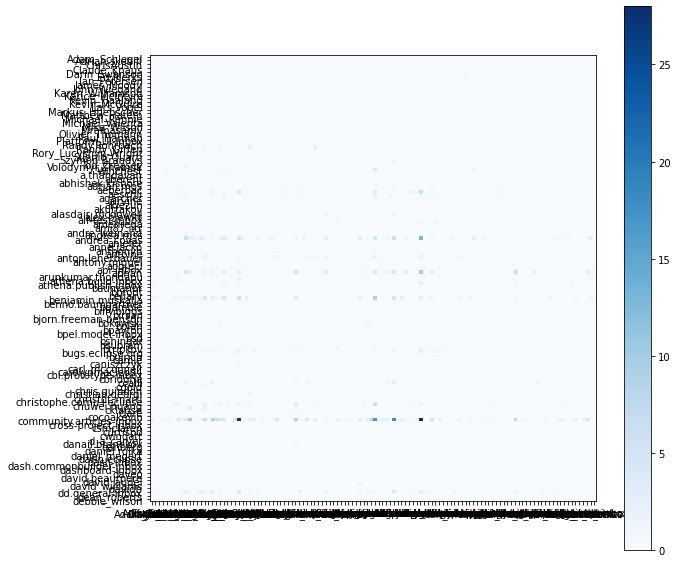

In [43]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Blues)
plt.colorbar()

# BERT

# Instalando requerimentos

In [ ]:
!pip install transformers

# **Importações**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from IPython.display import Image